In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# # download jane-market-price-prediction dataset

# !pip install -q kaggle

# from google.colab import files

# # upload kaggle API file
# files.upload()

# # Registration check
# !ls -1ha kaggle.json

# # Setting for download kaggle dataset
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions list

# # Download jane-street-market-prediction dataset
# !kaggle competitions download -c jane-street-market-prediction

# # unzip data
# !unzip example_test.csv.zip
# !unzip train.csv.zip

# # copy data
# !cp -r *.csv /gdrive/MyDrive/colab/jane-street-market-prediction/input/data

# # # check data
# ls -l /gdrive/MyDrive/colab/jane-street-market-prediction/input/data

# 1st Week

## Objective
1. Comprehensive EDA of Competition
2. Understanding about LSTM
3. baseline implementation of LSTM in Jane Competition

### 1. Comprehensive EDA of Competition

#### References 

* Notebooks for EDA

  https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance

  https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda-pca-starter

  https://www.kaggle.com/hamzashabbirbhatti/eda-a-quant-s-prespective

* Understanding about metric

  https://www.kaggle.com/renataghisloti/understanding-the-utility-score-function 

* Insights for Features

  https://www.kaggle.com/nanomathias/feature-0-beyond-feature-0

  have perspective to use feature importance and score of Tree Model for looking at relationship between feature_0 and others.

In [3]:
import warnings
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

# install datatable
!pip install datatable
import datatable as dt

import gc

warnings.simplefilter(action="ignore")

project_home = "/gdrive/MyDrive/colab/jane-street-market-prediction"

     |████████████████████████████████| 83.7MB 87kB/s 


In [4]:
data_home = os.path.join(project_home, "input/data")

train_file = os.path.join(data_home,'train.csv')
train_data_datatable = dt.fread(train_file)

df_train = train_data_datatable.to_pandas()

#### Understanding about metric

* Metric (Utility Score)

  **Definition of Metric**

  for each date i, we define
  $$
  p_i=\underset{j}{\sum}=(weight_{ij}*resp_{ij}*action_{ij}) \\
  t=\frac{\sum{p_i}}{\sqrt{\sum{p_i^2}}}*\sqrt{\frac{250}{|i|}} \\
  $$
  where |i| is the number of unique dates in the test set. The utility is then defined as:
  $$
  u = min(max(t,0),6)\sum{p_i}
  $$

  개별 Trade j는 결과를 계산하는데 사용되는 weight와 resp와 관련을 가지고 있다. 그리고 i는 test set의 날짜의 개수를 의미한다. 

  * $p_i$

    임의의 하루 i에 대해서 얼마나 그 날에 return을 얻어 낼 수 있는지를 대표하는 값. 그러나 p_i를 계산하는데 있어 action 값이 관여하지만, 이를 학습을 통해 예측해야하는 상황. 

    Utility Score; u를 최대화하라면 p_i를 또한 최대화 해야한다. 이는 음의 resp 값(only available value for negative)을 최대한 적게 select해야 한다. 

  * t

    t값은 예를 들어, test의 date가 2일만 주어졌고, 각각의 pi를 계산한 경우가 있다고 하자. t은 pi 값들의 분포가 고르고, 분산이 작은 경우에 값이 커지는 경향이 있다(left equation of t). 그리고 i값이 커지면 t의 값은 작아질 것이다(right equation of t).

    sharpe 지수를 매년 투자일을 250일로 가정했을때 년 단위로 변환하는 값. 만약 이값이 음수라면 utility가 0이기 떄문에 max(t,0)을 취했고 6보다 큰경우는 드물기 때문에 제한을 둔것.

  결과적으로, 큰 Utility Score를 위해서는 거래일별로 Return이 균등하게 분포해야 하고, 많은 날짜들을 고려할 수록 metric에 대한 페널티를 부여하게 된다.

  The utility function overall try to maximize the product of sharpe ratio and total return. 

In [5]:
df_train.head()

date     weight    resp_1  ...  feature_128  feature_129  ts_id
0     0   0.000000  0.009916  ...     2.301488    11.445807      0
1     0  16.673515 -0.002828  ...    -1.304614     1.898684      1
2     0   0.000000  0.025134  ...     6.638248     9.427299      2
3     0   0.000000 -0.004730  ...     3.856384     1.013469      3
4     0   0.138531  0.001252  ...     0.362636     3.926633      4

[5 rows x 138 columns]

#### EDA

1. weight

  weight have skewed distribution toward positive side. that's why there is outliers in postive side. There are many 0s in weight value, however, 0s is for data completeness and replaced when evaluation phase.

Text(0.5, 0.98, 'EDA about weight')

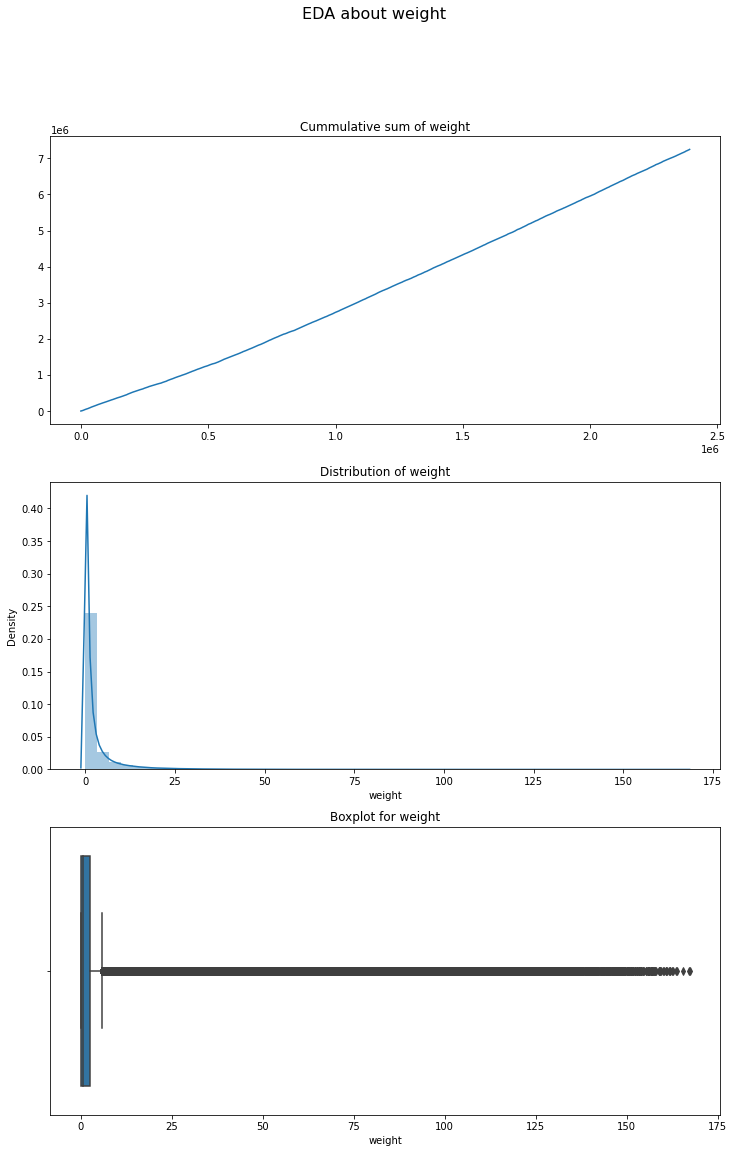

In [6]:
df_weight = df_train["weight"]

fig, axes = plt.subplots(3,1, figsize=[12,18])
df_weight.cumsum().plot(ax=axes[0])
axes[0].set_title("Cummulative sum of weight")
sns.distplot(df_weight,ax=axes[1])
axes[1].set_title("Distribution of weight")
sns.boxplot(df_weight,ax=axes[2])
axes[2].set_title("Boxplot for weight")

plt.suptitle("EDA about weight",size=16)

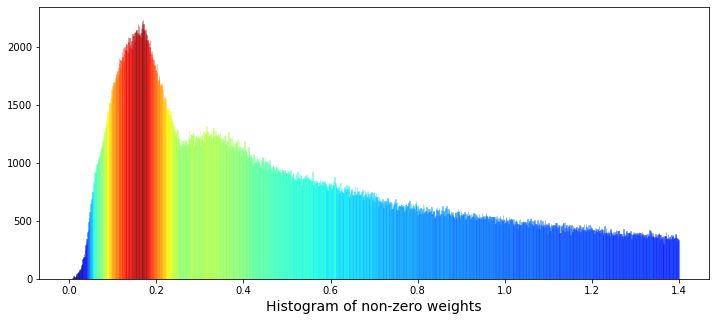

In [10]:
df_weight_non_0 = df_weight.loc[df_weight>0]

plt.figure(figsize = (12,5))
ax = sns.distplot(df_weight_non_0, 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values
gc.collect();

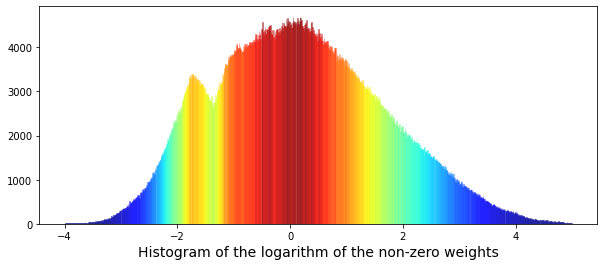

In [11]:
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(df_weight_non_0), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
plt.show();
gc.collect();

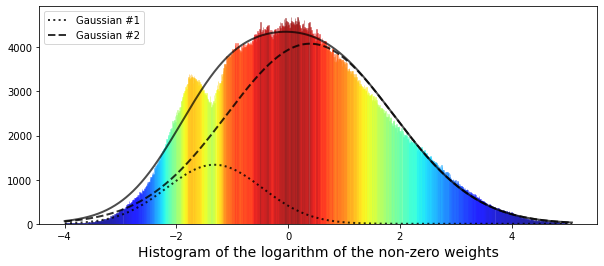

In [12]:
from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [(i/110)-4 for i in x]
y = values

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

def bimodal(x,mu_1,sigma_1,A_1,mu_2,sigma_2,A_2):
    return Gaussian(x,mu_1,sigma_1,A_1) + Gaussian(x,mu_2,sigma_2,A_2)

# seed guess
initial_guess=(1, 1 , 1,    1, 1, 1)

# the fit
parameters,covariance=curve_fit(bimodal,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# the plot
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(df_weight_non_0), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
# plot gaussian #1
plt.plot(x,Gaussian(x,parameters[0],parameters[1],parameters[2]),':',color='black',lw=2,label='Gaussian #1', alpha=0.8)
# plot gaussian #2
plt.plot(x,Gaussian(x,parameters[3],parameters[4],parameters[5]),'--',color='black',lw=2,label='Gaussian #2', alpha=0.8)
# plot the two gaussians together
plt.plot(x,bimodal(x,*parameters),color='black',lw=2, alpha=0.7)
plt.legend(loc="upper left");
plt.show();
del values
gc.collect();

##### 2. resp

resp = respond. There are 5 value for it.
1. resp
2. resp_{1,2,3,4}: respond for timehorizon of investment

* <a href="https://www.investopedia.com/terms/t/timehorizon.asp">The Basics of Investment Time Horizons</a>

  An Investment Time Horizon is the period where one expects to hold an investment for a specific goal. Investments are generally broken down into two main categories: stocks (riskier) and bonds (less risky). The longer the Time Horizon, the more aggressive, or riskier portfolio, an investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.

* Abstract about Resp

  **Low** Time Horizon: make a investment in conservative manner

  **High** Time Horizon: make a investment in aggresive manner 

In [13]:
resps = [col for col in df_train.columns if "resp" in col]

df_resps = df_train.loc[:,resps]

Text(0.5, 0.98, 'Distributions of Resps')

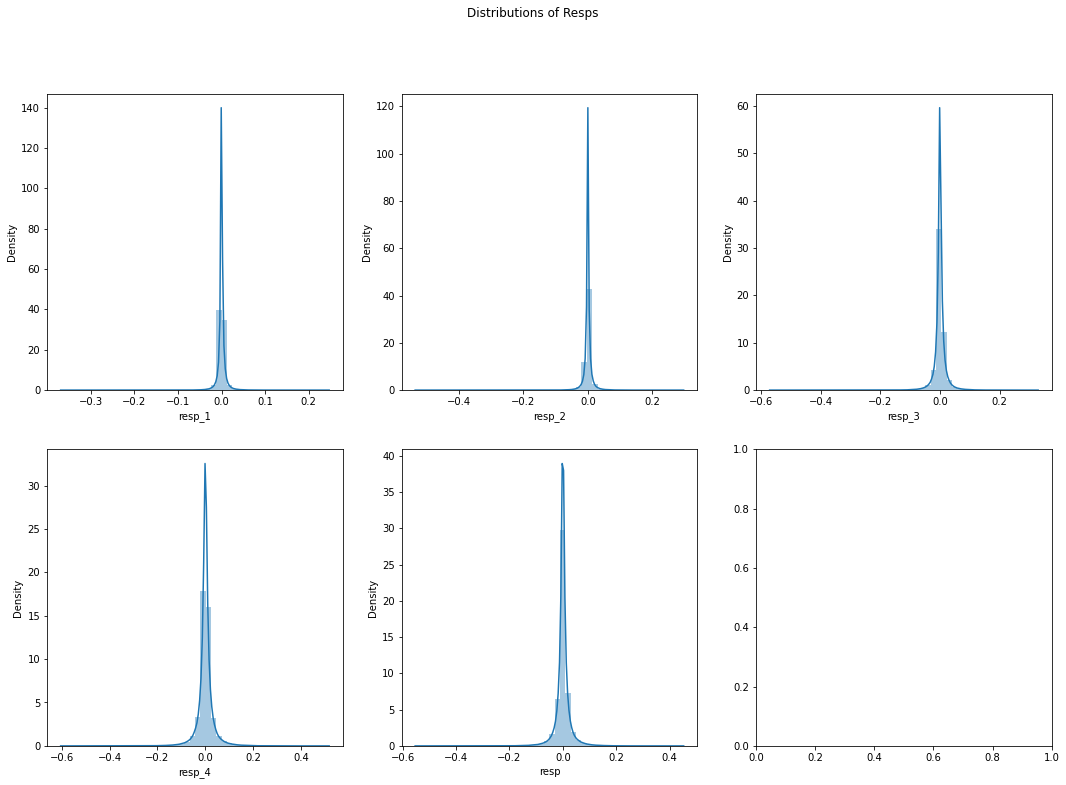

In [14]:
fig,axes = plt.subplots(2,3, figsize=[18,12])

for idx, resp in enumerate(resps):
  row = idx // 3
  col = idx % 3
  sns.distplot(df_resps[resp], ax=axes[row,col])

plt.suptitle("Distributions of Resps")

The distriubtion of Resp is Normal distribution what has mean 0.

In [15]:
df_resps

resp_1    resp_2    resp_3    resp_4      resp
0        0.009916  0.014079  0.008773  0.001390  0.006270
1       -0.002828 -0.003226 -0.007319 -0.011114 -0.009792
2        0.025134  0.027607  0.033406  0.034380  0.023970
3       -0.004730 -0.003273 -0.000461 -0.000476 -0.003200
4        0.001252  0.002165 -0.001215 -0.006219 -0.002604
...           ...       ...       ...       ...       ...
2390486  0.000142  0.000142  0.005829  0.020342  0.015396
2390487  0.000012  0.000012 -0.000935 -0.006326 -0.004718
2390488  0.000499  0.000499  0.007605  0.024907  0.016591
2390489 -0.000156 -0.000156 -0.001375 -0.003702 -0.002004
2390490 -0.001855 -0.001855 -0.001194 -0.000864 -0.001905

[2390491 rows x 5 columns]

Text(0.5, 0.98, 'cumsum of resps')

<Figure size 1080x360 with 0 Axes>

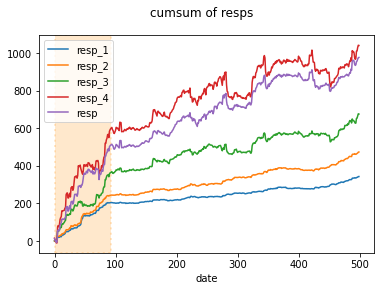

In [16]:
plt.figure(figsize=(15,5))

df_resps_cumsum = df_train.loc[:,["date"]+resps].groupby("date").sum().cumsum()
df_resps_cumsum.plot()
plt.axvspan(0,92,linestyle=":",linewidth=2,label="first 92 days",color="darkorange",alpha=.2)
plt.suptitle("cumsum of resps")

The trend of resps are changed from basis of day 92. It means the investment policy would be changed. So, kaggler proved empirical way of it because the prediction performance improved when it was removed before day 92 data.

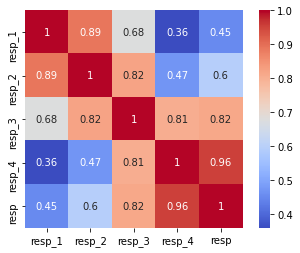

In [17]:
df_corr_resps = df_resps.corr()
sns.heatmap(df_corr_resps, cmap="coolwarm",annot=True,square=True)

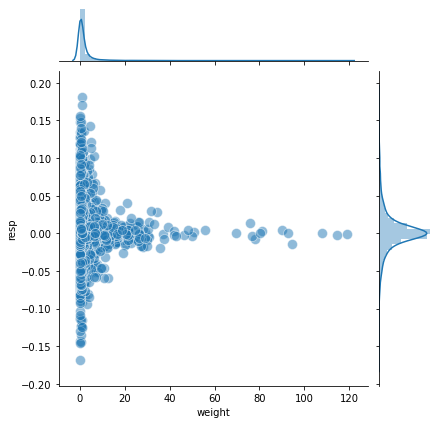

In [18]:
df_day_0 = df_train.loc[df_train.date==0]

g = sns.JointGrid(data=df_day_0, x="weight", y="resp")
g.plot_joint(sns.scatterplot, s=100, alpha=.5)
g.plot_marginals(sns.distplot, kde=True)

There is no linear correlationship between two variable. but resp close with 0 weight value gonna be high like above. 

##### 3. Time (Date)



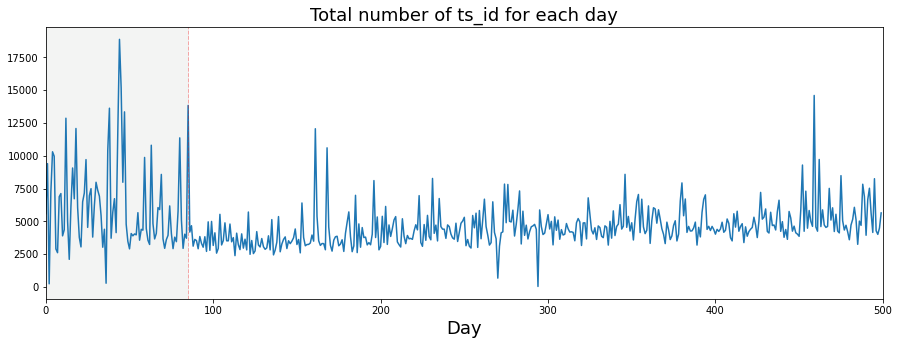

In [19]:
trades_per_day = df_train.groupby(['date'])['ts_id'].count()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of ts_id for each day", fontsize=18)
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
plt.show()

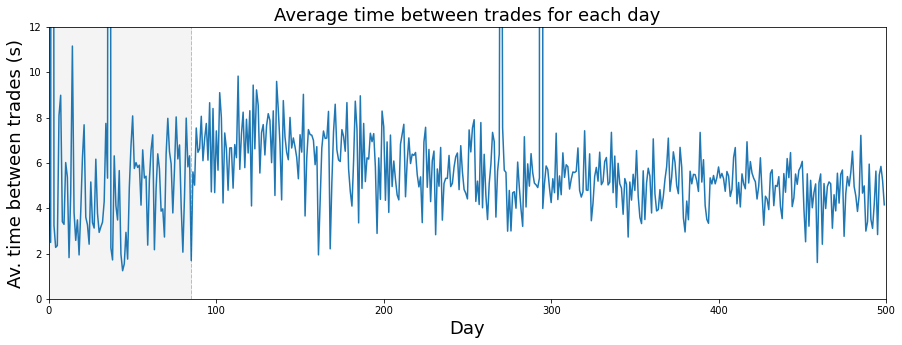

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
# 23400s -> 6.5h; duration of trading time daily
plt.plot(23400/trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_ylabel ("Av. time between trades (s)", fontsize=18)
ax.set_title ("Average time between trades for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=12)
plt.show()

The change frequnecy and amount of trading could be another evidence to notify investment startegy is changed.

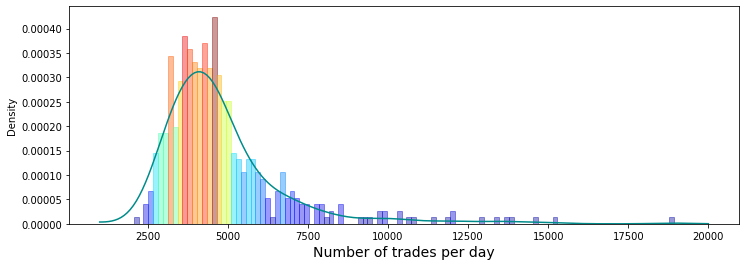

In [21]:
plt.figure(figsize = (12,4))
# the minimum has been set to 1000 so as not to draw the partial days like day 2 and day 294
# the maximum number of trades per day is 18884
# I have used 125 bins for the 500 days
ax = sns.distplot(trades_per_day, 
             bins=125, 
             kde_kws={"clip":(1000,20000)}, 
             hist_kws={"range":(1000,20000)},
             color='darkcyan', 
             kde=True);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Number of trades per day", size=14)
plt.show();

##### 4. features



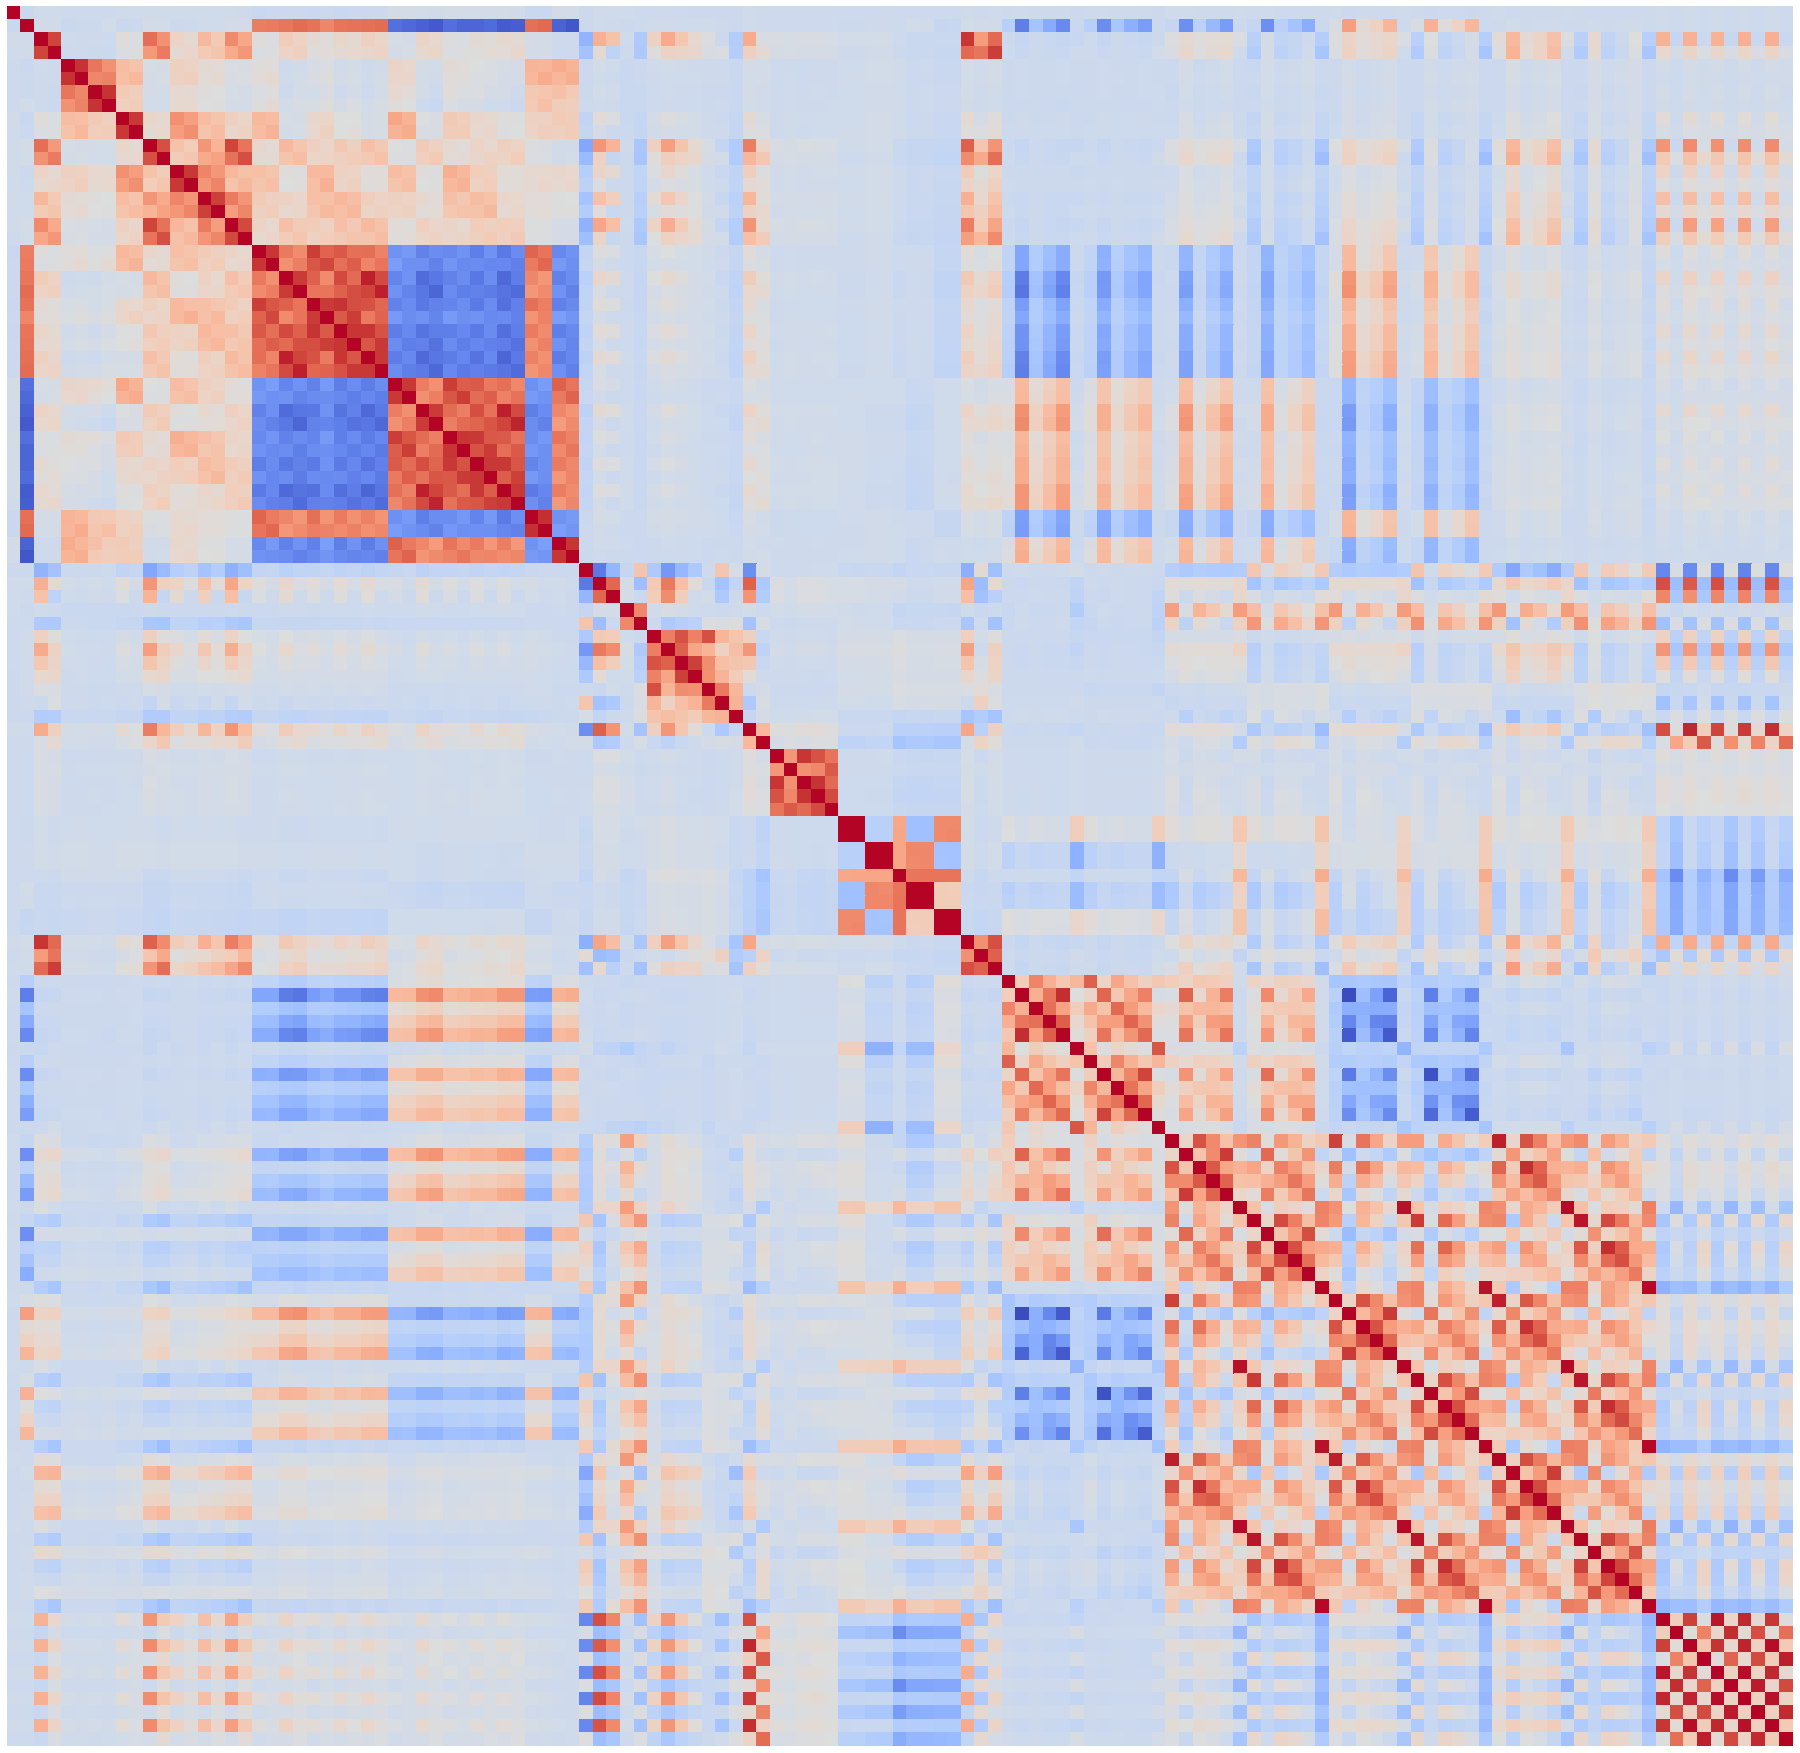

In [34]:
features = [ col for col in df_train.columns if "feature" in col ]
resp_features = ["resp"] + features

df_corr_features = df_train.loc[:, resp_features]
df_corr_features = df_corr_features.corr()
plt.figure(figsize=(32,32))
sns.heatmap(df_corr_features,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap="coolwarm");

Text(0.5, 0.89, 'Overall Distribution per features_0-29 [dist, box, scatter, cumsum]')

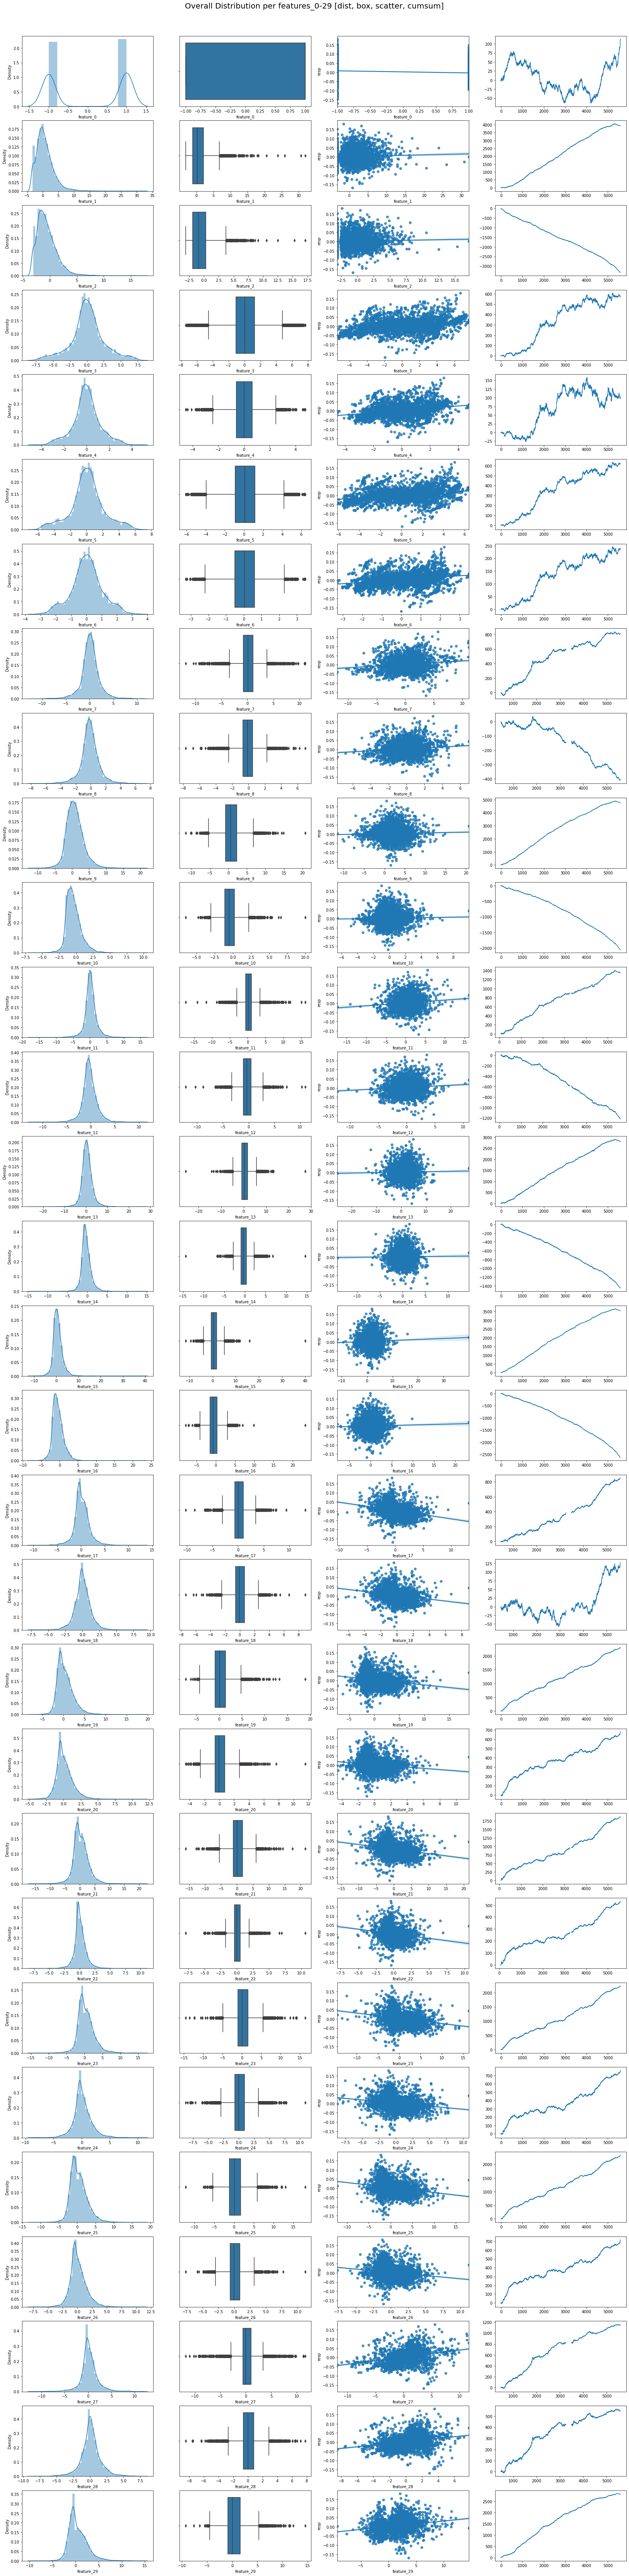

In [81]:
features_list = [features[i*30:(i+1)*30]for i in range(5)]
resp_features = [["resp"]+ features for features in features_list]

df_resp_features_0 = df_day_0.loc[:, resp_features[0]]

fig, axes = plt.subplots(30,4,figsize=[28,120])

for idx, col in enumerate(tqdm_notebook(resp_features[0][1:])):
  targets = ["resp"] + [col]
  
  df_target = df_resp_features_0.loc[:,targets]
  # 1. distplot
  sns.distplot(df_target[col], ax=axes[idx,0])
  # 2. boxplot
  sns.boxplot(df_target[col], ax=axes[idx,1])
  # 3. scatterplot with resp
  sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
  # 4. cumulative data
  df_target[col].cumsum().plot(ax=axes[idx,3])

plt.suptitle("Overall Distribution per features_0-29 [dist, box, scatter, cumsum]",y=0.89, size=20)

Text(0.5, 0.89, 'Overall Distribution per features_30-59 [dist, box, scatter, cumsum]')

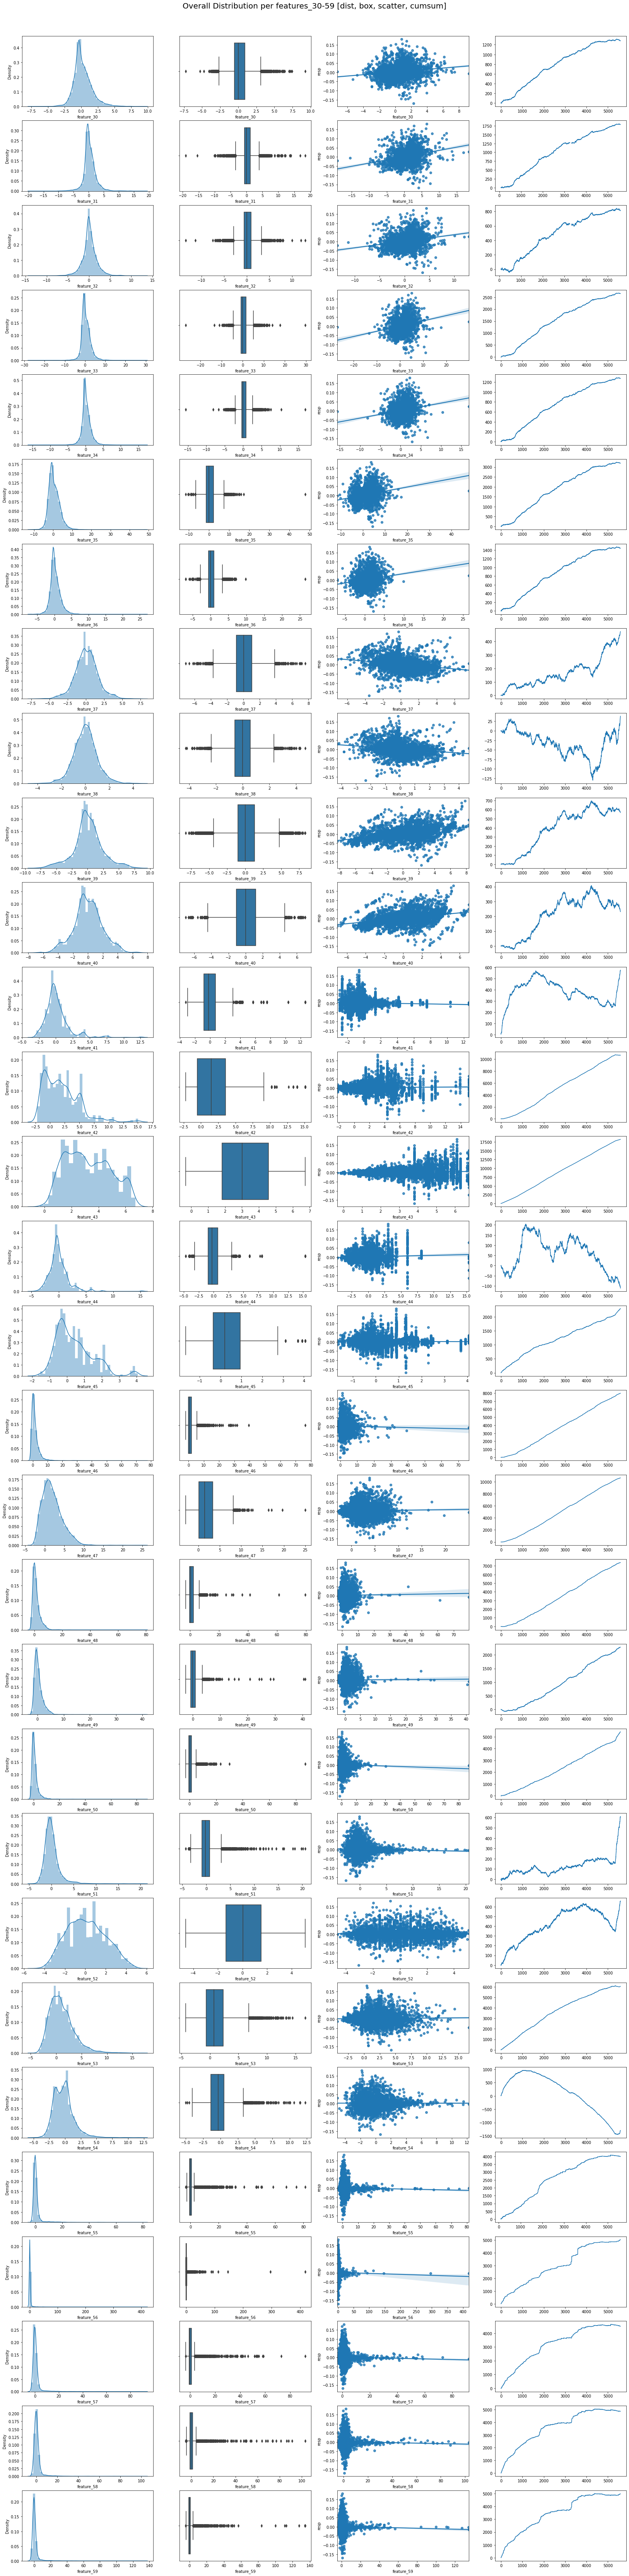

In [82]:
df_resp_features_1 = df_day_0.loc[:, resp_features[1]]

fig, axes = plt.subplots(30,4,figsize=[28,120])

for idx, col in enumerate(tqdm_notebook(resp_features[1][1:])):
  targets = ["resp"] + [col]
  
  df_target = df_resp_features_1.loc[:,targets]
  # 1. distplot
  sns.distplot(df_target[col], ax=axes[idx,0])
  # 2. boxplot
  sns.boxplot(df_target[col], ax=axes[idx,1])
  # 3. scatterplot with resp
  sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
  # 4. cumulative data
  df_target[col].cumsum().plot(ax=axes[idx,3])

plt.suptitle("Overall Distribution per features_30-59 [dist, box, scatter, cumsum]",y=0.89, size=20)

Text(0.5, 0.89, 'Overall Distribution per features_60-89 [dist, box, scatter, cumsum]')

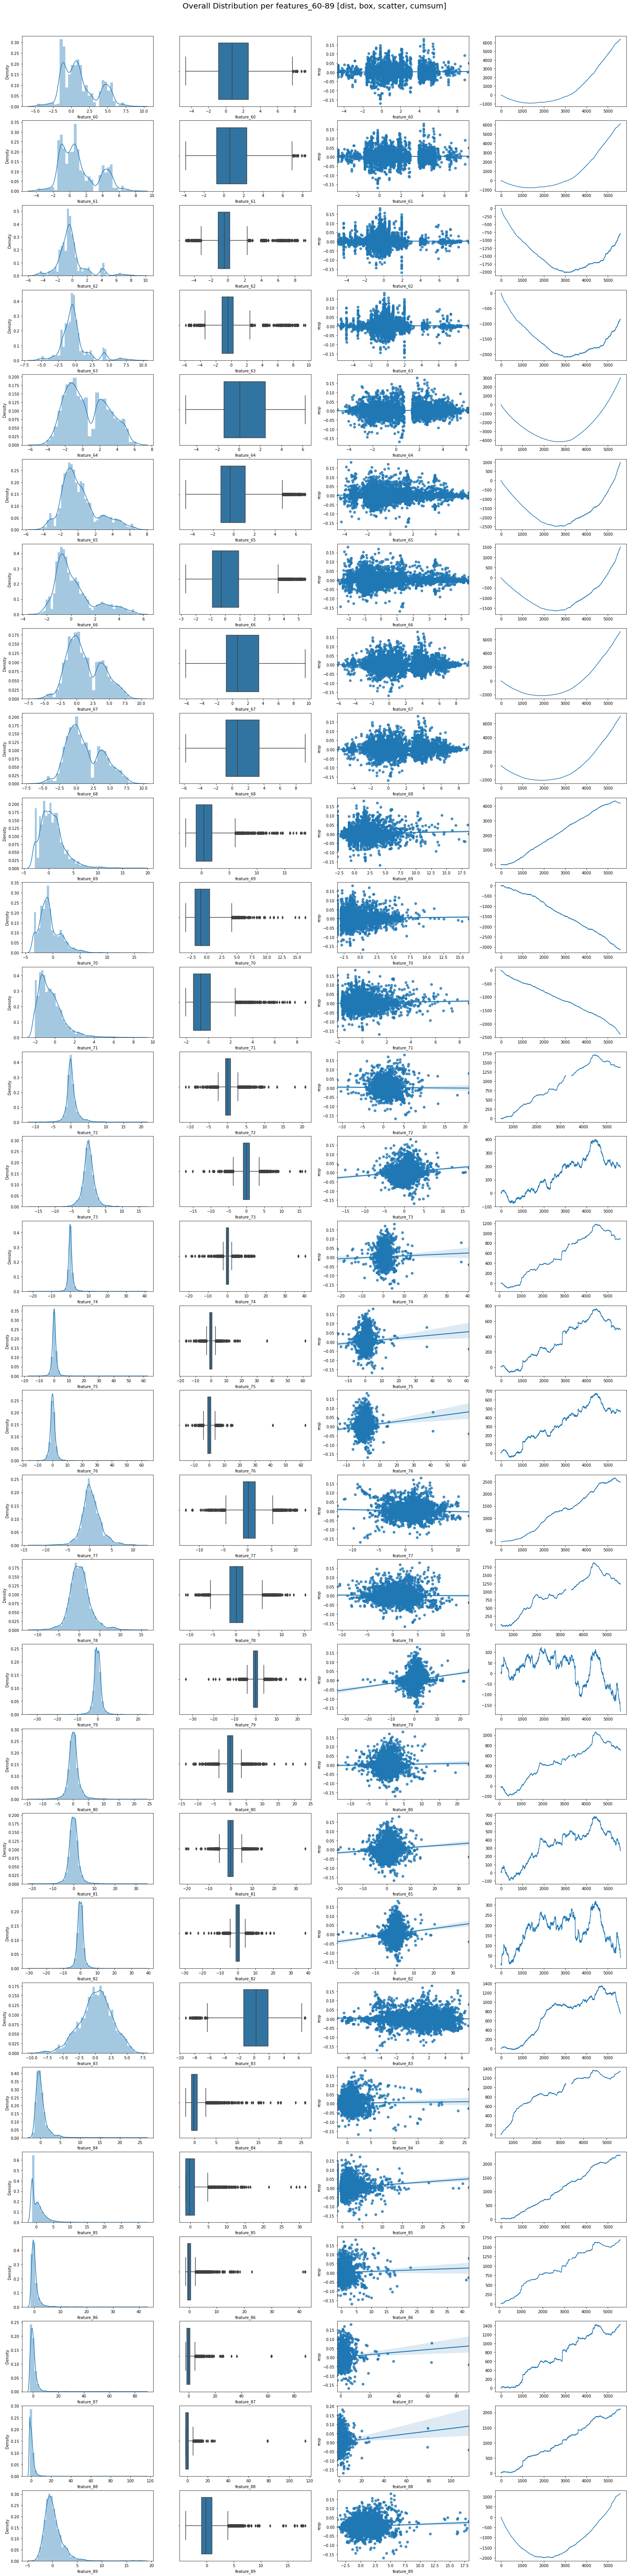

In [83]:
df_resp_features_2 = df_day_0.loc[:, resp_features[2]]

fig, axes = plt.subplots(30,4,figsize=[28,120])

for idx, col in enumerate(tqdm_notebook(resp_features[2][1:])):
  targets = ["resp"] + [col]
  
  df_target = df_resp_features_2.loc[:,targets]
  # 1. distplot
  sns.distplot(df_target[col], ax=axes[idx,0])
  # 2. boxplot
  sns.boxplot(df_target[col], ax=axes[idx,1])
  # 3. scatterplot with resp
  sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
  # 4. cumulative data
  df_target[col].cumsum().plot(ax=axes[idx,3])

plt.suptitle("Overall Distribution per features_60-89 [dist, box, scatter, cumsum]",y=0.89, size=20)

Text(0.5, 0.89, 'Overall Distribution per features_90-119 [dist, box, scatter, cumsum]')

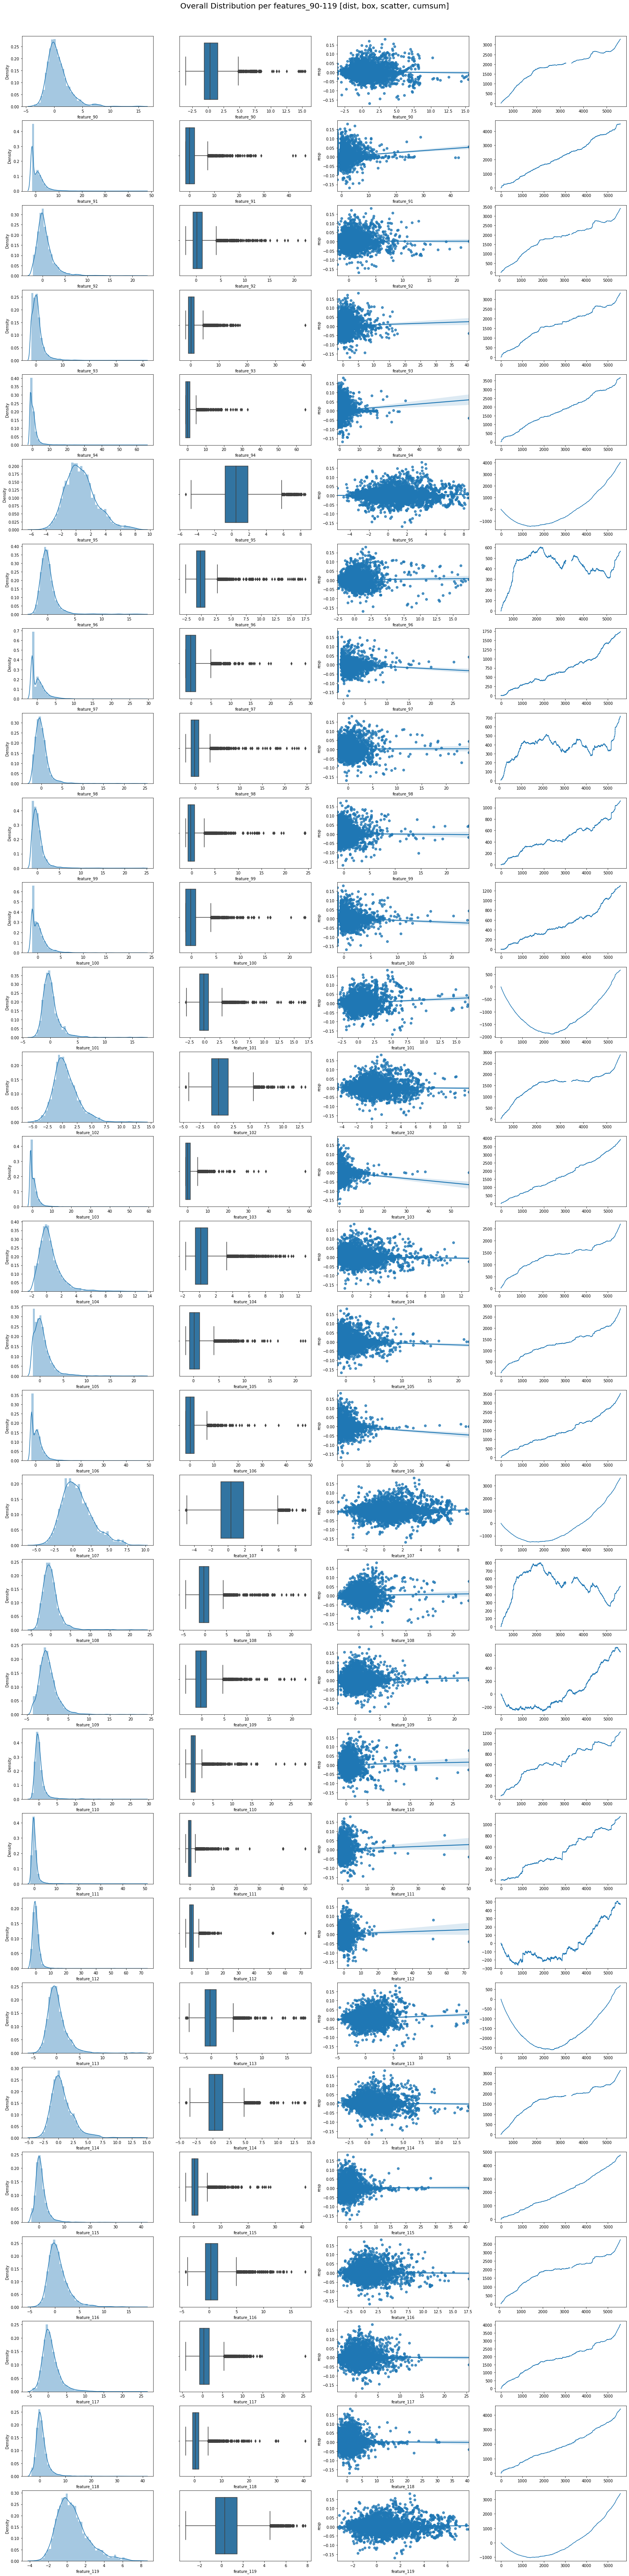

In [84]:
df_resp_features_3 = df_day_0.loc[:, resp_features[3]]

fig, axes = plt.subplots(30,4,figsize=[28,120])

for idx, col in enumerate(tqdm_notebook(resp_features[3][1:])):
  targets = ["resp"] + [col]
  
  df_target = df_resp_features_3.loc[:,targets]
  # 1. distplot
  sns.distplot(df_target[col], ax=axes[idx,0])
  # 2. boxplot
  sns.boxplot(df_target[col], ax=axes[idx,1])
  # 3. scatterplot with resp
  sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
  # 4. cumulative data
  df_target[col].cumsum().plot(ax=axes[idx,3])

plt.suptitle("Overall Distribution per features_90-119 [dist, box, scatter, cumsum]",y=0.89, size=20)

Text(0.5, 0.89, 'Overall Distribution per features_120-130 [dist, box, scatter, cumsum]')

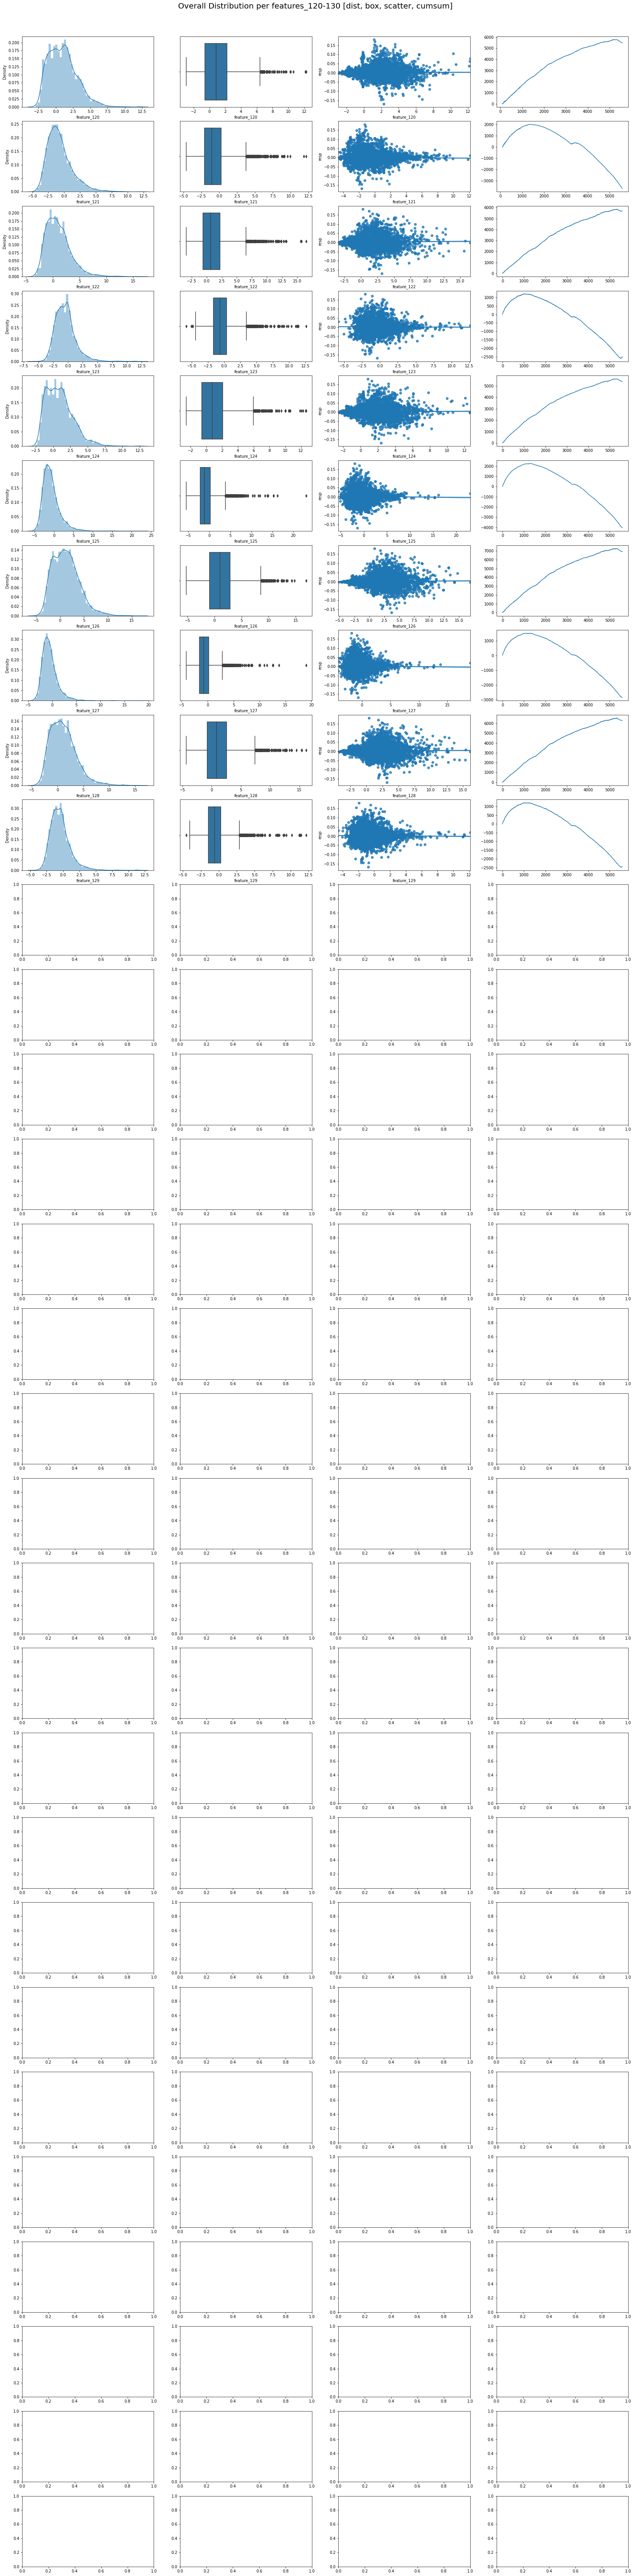

In [85]:
df_resp_features_4 = df_day_0.loc[:, resp_features[4]]

fig, axes = plt.subplots(30,4,figsize=[28,120])

for idx, col in enumerate(tqdm_notebook(resp_features[4][1:])):
  targets = ["resp"] + [col]
  
  df_target = df_resp_features_4.loc[:,targets]
  # 1. distplot
  sns.distplot(df_target[col], ax=axes[idx,0])
  # 2. boxplot
  sns.boxplot(df_target[col], ax=axes[idx,1])
  # 3. scatterplot with resp
  sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
  # 4. cumulative data
  df_target[col].cumsum().plot(ax=axes[idx,3])

plt.suptitle("Overall Distribution per features_120-130 [dist, box, scatter, cumsum]",y=0.89, size=20)

In [31]:
features = [ col for col in df_train.columns if "feature" in col ]
df_features = df_train.loc[:, features + ["ts_id"]]
df_features.head()

feature_0  feature_1  feature_2  ...  feature_128  feature_129  ts_id
0          1  -1.872746  -2.191242  ...     2.301488    11.445807      0
1         -1  -1.349537  -1.704709  ...    -1.304614     1.898684      1
2         -1   0.812780  -0.256156  ...     6.638248     9.427299      2
3         -1   1.174378   0.344640  ...     3.856384     1.013469      3
4          1  -3.172026  -3.093182  ...     0.362636     3.926633      4

[5 rows x 131 columns]

In [35]:
len(features)

130

#### LSTM baseline code

* Reference 

  https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data

#### Recurrent Neural Network; RNN

* RNN

  Traditional Neural Net cannot have persistance(means make a prediction with far previous information; i.e. reading a book). RNN address this issue.

  <div align="center">
  <img src="imgs/RNN-rolled.png" />
  </div>

  A(neural net), xt(input), ht(output). The loop above makes information to be passed from one step to next. 

  <div align="center">
  <img src="imgs/RNN-unrolled.png" />
  </div>

  But RNN could be made by simple NN structure. it just mutiple copies of same network, each passing a message to a successor. This chain-like nature reveals that recurrent neural networks are **intimately related to sequences and lists**. They’re the natural architecture of neural network to use for such data(i.e. speech recognition, language modeling, translation, image captioning… The list goes on).

  Essential to these successes is **the use of “LSTMs,”** a very special kind of recurrent neural network which works, for many tasks, **much much better than the standard version**. Almost all exciting results based on recurrent neural networks are achieved with them. It’s these LSTMs that this essay will explore.

* The Problem of Long-Term Dependencies

  One of the appeals of RNNs is **the idea that they might be able to connect previous information to the present task**, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? **It depends.**

  **Sometimes, we only need to look at recent information** to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the sky,” **we don’t need any further context** – it’s pretty obvious the next word is going to be sky. In such cases, **where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.RNN-shorttermdepdencies

  <div align="center">
    <img src="imgs/RNN-shorttermdepdencies.png" />
  </div>

  But there are also **cases where we need more context**. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for **the gap between the relevant information and the point where it is needed to become very large.**

  **Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.**

  <div align="center">
    <img src="imgs/RNN-longtermdepdencies.png" />
  </div>

* LSTM Networks

  LSTMs are explicitly designed to avoid the long-term dependency problem. **Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!**

  All recurrent neural networks have **the form of a chain of repeating modules of neural network**. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

  <div align="center">
    <img src="imgs/LSTM3-SimpleRNN.png" />
  </div>

  LSTMs also have this chain like structure, **but the repeating module has a different structure**. Instead of having a single neural network layer, **there are four, interacting in a very special way.**

  <div align="center">
    <img src="imgs/LSTM3-chain.png" />
  </div>

  Don’t worry about the details of what’s going on. We’ll walk through the LSTM diagram step by step later. For now, let’s just try to get comfortable with the notation we’ll be using.

  <div align="center">
    <img src="imgs/LSTM2-notation.png" />
  </div>  

  In the above diagram, **each line carries an entire vector**, from the output of one node to the inputs of others. **The pink circles represent pointwise operations**, like vector addition, while **the yellow boxes are learned neural network layers**. **Lines merging denote concatenation**, while a line **forking denote its content being copied** and the copies going to different locations.

* The Core Idea Behind LSTMs

  The key to LSTMs is **the cell state, the horizontal line running through the top of the diagram**.

  The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. **It’s very easy for information to just flow along it unchanged**.

  <div align="center">
    <img src="imgs/LSTM3-C-line.png" />
  </div>  

  The LSTM does have **the ability to remove or add information to the cell state**, **carefully regulated by structures called gates.**

  **Gates are a way to optionally let information through.** They are composed out of **a sigmoid neural net layer and a pointwise multiplication operation.**

  <div align="center">
    <img src="imgs/LSTM3-gate.png" />
  </div>  

  **The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through.** **A value of zero** means “let nothing through,” while **a value of one means** “let everything through!”

  An LSTM has three of these gates, to protect and control the cell state.

* Step-by-Step LSTM Walk Through
